Discretizing the structure and solving the optimization problem using cvxpy to minimize the weighted 1-norm of the force densitites

In [ ]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import cvxpy as cp

# Set the dimensions of the grid where the nodes will be placed.
L = 4  # Length of the grid.
w = 1  # Width of the grid.
dx = 0.25  # Horizontal spacing between nodes.
dy = dx  # Vertical spacing between nodes, same as horizontal.

# Radius for connecting nodes, slightly larger than the diagonal distance to ensure connectivity.
r = np.sqrt(dx**2 + dy**2) * 1.1

# Create a grid of points using meshgrid.
x = np.arange(0, L + dx, dx)  # All x coordinates from 0 to L with spacing dx.
y = np.arange(0, w + dy, dy)  # All y coordinates from 0 to w with spacing dy.
X, Y = np.meshgrid(x, y)  # Create a 2D grid of x and y coordinates.
Nodes_2D = np.vstack((X.flatten(), Y.flatten())).T  # Flatten the grid into a list of node coordinates.
n = len(Nodes_2D)  # Total number of nodes.

# Add a third dimension of zeros to Nodes for z-coordinates
Nodes = np.hstack((Nodes_2D, np.zeros((n, 1)))).T  # Transposed to match the shape (3, n)

# KDTree for efficient neighbor searching.
tree = KDTree(Nodes_2D)
# Find indices of nodes within a radius 'r' for each node.
Idx = tree.query_ball_point(Nodes_2D, r)

# Filter self indices to prevent a node from connecting to itself.
Idx_filtered = [np.array(list(filter(lambda x: x != i, idx))) for i, idx in enumerate(Idx)]

# Generate connectivity matrix where each row represents a member connecting two nodes.
C = []
for i, indices in enumerate(Idx_filtered):
    for j in indices:
        if i < j:  # Ensure each connection is only represented once.
            connection = np.zeros(n)
            connection[i] = 1
            connection[j] = -1
            C.append(connection)
C = np.array(C)
m = len(C)  # Total number of unique members.

# Determine the node where the external force will be applied.
# Calculate nodes per column for a vertically stacked list of nodes.
nodes_per_column = int(n / (L/dx + 1))
# Find the middle node at the right end of the grid to apply the load.
iLoadNode = nodes_per_column * (int(L/dx)) + int(nodes_per_column/2)

# Initialize the external force array with zeros.
F_ext_2D = np.zeros((n, 2))
# Apply a unit load in the negative y-direction at the load node.
F_ext_2D[iLoadNode, 1] = -1000

# Extend the force array to 3D (z-direction is zero).
F_ext = np.vstack((F_ext_2D.T, np.zeros(n)))

# Identify nodes where reactions will occur (fixed nodes at x=0).
iReactionNodes = np.where(Nodes_2D[:, 0] == 0)[0]

# Set up variables for the optimization problem.
sig = cp.Variable(m)  # Variable for internal member forces.
r = cp.Variable((len(iReactionNodes), 2))  # Variables for reaction forces.

# Reshape R to include z-direction as zeros
R = cp.Variable((3, n))

# Prepare equilibrium constraints.
equilibrium_constraints = []
# Constraint for reaction forces at the reaction nodes.
for i, node_idx in enumerate(iReactionNodes):
    # Ensure sum of forces equals reaction force at each reaction node.
    equilibrium_constraints += [
        cp.constraints.NonPos(cp.sum(R[:, node_idx]) - r[node_idx//17, node_idx%17])
    ]

# Constraint for global equilibrium of the structure.
equilibrium_constraints += [
    cp.sum(cp.multiply(C, cp.reshape(sig, (m, 1))), axis=0, keepdims=True) == F_ext - R
]

# Define the objective function: Minimize the weighted 1-norm of the force densities.
w = cp.Parameter(m, nonneg=True)  # Weights for the 1-norm.
w.value = np.ones(m)  # Initialize weights to 1.
objective = cp.Minimize(cp.norm(w @ sig, 1))

# Create and solve the optimization problem.
prob = cp.Problem(objective, equilibrium_constraints)
prob.solve(verbose=True)

# Extract results from the optimization problem.
optimized_sig = sig.value  # Optimized internal forces.
optimized_r = r.value  # Optimized reaction forces.

# Calculate and print the total mass of the structure.
structure_mass = cp.norm(w @ optimized_sig, 1).value
print("Structure mass:", structure_mass)

# Print the optimized member forces and reaction forces.
print("Optimized member forces:", optimized_sig)
print("Reaction forces at fixed nodes:", optimized_r.T)



                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Feb 23 03:08:36 AM: Your problem has 541 variables, 6 constraints, and 276 parameters.
(CVXPY) Feb 23 03:08:36 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 23 03:08:36 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 23 03:08:36 AM: Compiling problem (target solver=ECOS).
(CVXPY) Feb 23 03:08:36 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Feb 23 03:08:36 AM: Applying reduction Dcp2Cone
(CVXPY) Feb 23 03:08:36 AM: Applying reduction CvxAttr2Constr
(CVXP

In [ ]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
'''
force_threshold = 0.001  # Define a threshold for significant force
significant_member_indices = [i for i, force in enumerate(optimized_sig) if abs(force) > force_threshold]
# Filter C and optimized_sig to only include significant members
C_significant = C[significant_member_indices]
optimized_sig_significant = optimized_sig[significant_member_indices]
'''

'\nforce_threshold = 0.001  # Define a threshold for significant force\nsignificant_member_indices = [i for i, force in enumerate(optimized_sig) if abs(force) > force_threshold]\n# Filter C and optimized_sig to only include significant members\nC_significant = C[significant_member_indices]\noptimized_sig_significant = optimized_sig[significant_member_indices]\n'

In [ ]:
'''
# Define a function to plot the structure with optimized member forces.
def improved_plot_structure(Nodes, C_significant, significant_member_forces):
    # Initialize the plot with matplotlib.
    fig, ax = plt.subplots()

    # Plot only the members that carry significant forces after optimization.
    for i, connection in enumerate(C_significant):
        node_indices = np.where(connection == 1)[0]
        for node_idx in node_indices:
            # Find the other node this connection links to.
            other_node_idx = np.where(connection == -1)[0][0]
            # Get the x, y coordinates of the two nodes this member connects.
            x_coords = Nodes[[node_idx, other_node_idx], 0]
            y_coords = Nodes[[node_idx, other_node_idx], 1]
            # Determine color based on whether the member force is tensile or compressive.
            color = 'r' if significant_member_forces[i] > 0 else 'b'
            # Plot the member.
            ax.plot(x_coords, y_coords, c=color, lw=2)

    # Add a scatter plot for the nodes with a larger size and green color.
    ax.scatter(Nodes[:, 0], Nodes[:, 1], s=50, color='green', zorder=5)

    # Set labels and title for the plot for better readability.
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Structure with Optimized Member Forces')
    ax.grid(True)  # Add a grid to the plot for reference.

    # Define custom legend entries for the plot.
    red_patch = plt.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Nodes')
    red_line = plt.Line2D([], [], color='red', lw=2, label='Tensile Members')
    blue_line = plt.Line2D([], [], color='blue', lw=2, label='Compressive Members')

    # Create and add the legend to the plot with the custom entries.
    ax.legend(handles=[red_patch, red_line, blue_line])

    plt.show()  # Display the plot.

# Call the function with the nodes, filtered connectivity matrix, and filtered optimized member forces.
improved_plot_structure(Nodes_2D, C, optimized_sig)
'''

"\n# Define a function to plot the structure with optimized member forces.\ndef improved_plot_structure(Nodes, C_significant, significant_member_forces):\n    # Initialize the plot with matplotlib.\n    fig, ax = plt.subplots()\n\n    # Plot only the members that carry significant forces after optimization.\n    for i, connection in enumerate(C_significant):\n        node_indices = np.where(connection == 1)[0]\n        for node_idx in node_indices:\n            # Find the other node this connection links to.\n            other_node_idx = np.where(connection == -1)[0][0]\n            # Get the x, y coordinates of the two nodes this member connects.\n            x_coords = Nodes[[node_idx, other_node_idx], 0]\n            y_coords = Nodes[[node_idx, other_node_idx], 1]\n            # Determine color based on whether the member force is tensile or compressive.\n            color = 'r' if significant_member_forces[i] > 0 else 'b'\n            # Plot the member.\n            ax.plot(x_coord

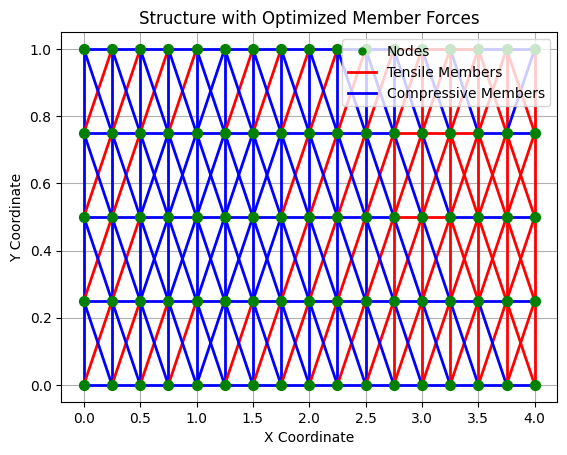

Solver status: optimal


In [ ]:
# Define a function to plot the structure with optimized member forces.
def improved_plot_structure(Nodes, C, member_forces):
    # Initialize the plot with matplotlib.
    fig, ax = plt.subplots()

    # Plot all potential members in light grey to indicate initial design.
    for connection in C:
        idx = np.where(connection != 0)[0]  # Get indices of nodes connected by the member.
        ax.plot(Nodes[idx, 0], Nodes[idx, 1], c='lightgrey', lw=1, alpha=0.5)

    # Plot only the members that carry significant forces after optimization.
    for i, connection in enumerate(C):
        idx = np.where(connection != 0)[0]  # Indices of nodes for this member.
        if abs(member_forces[i]) > 0:  # Check if member force is significant (non-zero).
            color = 'r' if member_forces[i] > 0 else 'b'  # Tensile in red, compressive in blue.
            ax.plot(Nodes[idx, 0], Nodes[idx, 1], c=color, lw=2)

    # Add a scatter plot for the nodes with a larger size and green color.
    ax.scatter(Nodes[:,0], Nodes[:,1], s=50, color='green', zorder=5)

    # Set labels and title for the plot for better readability.
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Structure with Optimized Member Forces')
    ax.grid(True)  # Add a grid to the plot for reference.

    # Define custom legend entries for the plot.
    red_patch = plt.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Nodes')
    red_line = plt.Line2D([], [], color='red', lw=2, label='Tensile Members')
    blue_line = plt.Line2D([], [], color='blue', lw=2, label='Compressive Members')

    # Create and add the legend to the plot with the custom entries.
    ax.legend(handles=[red_patch, red_line, blue_line])

    plt.show()  # Display the plot.

# Call the function with the nodes, connectivity matrix, and optimized member forces.
improved_plot_structure(Nodes_2D, C, optimized_sig)

# Print the status of the solver after solving the optimization problem.
print("Solver status:", prob.status)


In [ ]:
# Define the material properties and safety factors
density = 2810  # kg/m³ for aluminum alloy 7075-T6
yield_stress = 503e6  # Pa (503 MPa)
modulus_of_elasticity = 71.7e9  # Pa (71.7 GPa)
safety_factor = 1  # Safety factor value

# Placeholder for `Nodes` and `C` arrays based on your structural analysis results
# These should be replaced with the actual node coordinates and connectivity matrix
#Nodes = np.array([Nodes])  # Replace with actual node coordinates
#C = np.array([C])  # Replace with actual connectivity matrix
#optimized_sig = np.array([optimized_sig])  # Replace with actual member forces from optimization

# Initialize the list to hold the mass of each member
member_masses = []
member_force = []  # Store whether the member is in tension or compression

# Assuming 'Nodes', 'C', and 'optimized_sig' are defined in your environment
# Loop through each member defined by the connectivity matrix C
for i, connection in enumerate(C):
    indices = np.flatnonzero(connection)
    if len(indices) == 2:
        # Get node indices for both ends of the member
        node1_index, node2_index = indices
        # Retrieve coordinates for both nodes
        node1 = Nodes[:, node1_index]
        node2 = Nodes[:, node2_index]
        # Calculate member length
        length = np.linalg.norm(node1 - node2)
        # Get force for the current member
        force = optimized_sig[i]
        # Calculate absolute value of the force
        force_abs = abs(force)

        # Check if the member is in tension or compression
        # Initialize radius to None or a default value before the if-else block
        radius = 0  # Default value indicating it's not calculated yet
        if force > 0:
            member_force.append('Tension')
            # Calculate required area based on tensile strength
            area_required = force_abs / (yield_stress / safety_factor)
        else:
            member_force.append('Compression')
            # For compression, calculate required area based on buckling criteria
            effective_length_factor = 1.0  # Assume pinned-pinned ends for simplicity
            le = effective_length_factor * length
            # Calculate radius based on Euler's buckling formula
            radius = ((4 * force_abs * le**2) / (np.pi**2 * modulus_of_elasticity))**0.25
            area_required = np.pi * radius**2

        # Compute volume and mass for the member
        volume = area_required * length
        mass = density * volume
        member_masses.append(mass)

        # Print member details including state, radius, and mass
        print(f"Member {i}: state = {member_force[-1]}, radius = {radius:.4e} m, mass = {mass:.4e} kg")
    else:
        # If a member does not have two nodes, print an error message
        print(f"Connection {i} does not have two nodes.")
        member_masses.append(0)  # Append zero mass for this non-standard connection.

# Sum the masses of all members to get the total structure mass
total_structure_mass = sum(member_masses)
print(f"Total structure mass: {total_structure_mass:.4e} kg")


Member 0: state = Compression, radius = 1.0141e-03 m, mass = 2.2698e-03 kg
Member 1: state = Compression, radius = 5.0984e-04 m, mass = 5.7368e-04 kg
Member 2: state = Tension, radius = 0.0000e+00 m, mass = 3.8151e-06 kg
Member 3: state = Compression, radius = 1.1019e-03 m, mass = 2.6797e-03 kg
Member 4: state = Compression, radius = 1.2179e-03 m, mass = 4.6297e-03 kg
Member 5: state = Compression, radius = 7.6927e-04 m, mass = 1.3060e-03 kg
Member 6: state = Tension, radius = 0.0000e+00 m, mass = 1.3747e-06 kg
Member 7: state = Compression, radius = 1.1311e-03 m, mass = 2.8235e-03 kg
Member 8: state = Compression, radius = 1.1790e-03 m, mass = 4.3387e-03 kg
Member 9: state = Compression, radius = 7.7999e-04 m, mass = 1.3427e-03 kg
Member 10: state = Tension, radius = 0.0000e+00 m, mass = 4.6464e-07 kg
Member 11: state = Compression, radius = 1.1446e-03 m, mass = 2.8914e-03 kg
Member 12: state = Compression, radius = 1.1329e-03 m, mass = 4.0060e-03 kg
Member 13: state = Compression, ra

In [ ]:
# Initialize lists to hold indices of members to keep
indices_to_keep = []

# Filter member_forces using indices_to_keep
member_forces_filtered = [member_forces[i] for i in indices_to_keep]

for i, connection in enumerate(C):
    # Your existing code to calculate radius and mass
    # At the end of your existing loop:
    if radius > 0:
        indices_to_keep.append(i)
        print(f"Member {i}: state = {member_forces[-1]}, radius = {radius:.4e} m, mass = {mass:.4e} kg")
    else:
        print(f"Member {i} has radius 0 and will be excluded.")

# Filter C and optimized_sig using indices_to_keep
C_filtered = C[indices_to_keep, :]
optimized_sig_filtered = optimized_sig[indices_to_keep]

# Compute volume and mass for the member
volume = area_required * length
mass = density * volume
member_masses.append(mass)

# Print member details including state, radius, and mass
#print(f"Member {i}: state = {member_forces[-1]}, radius = {radius:.4e} m, mass = {mass:.4e} kg")

# Sum the masses of all members to get the total structure mass
total_structure_mass = sum(member_masses)
print(f"Total structure mass: {total_structure_mass:.4e} kg")

Member 0: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 1: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 2: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 3: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 4: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 5: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 6: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 7: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 8: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 9: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 10: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 11: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 12: state = Compression, radius = 1.5266e-03 m, mass = 5.1435e-03 kg
Member 13: state = Com

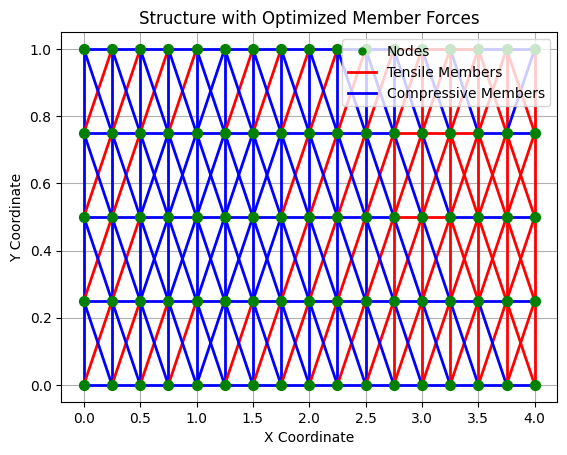

Solver status: optimal


In [ ]:
# Define a function to plot the structure with optimized member forces.
def improved_plot_structure(Nodes, C, member_forces):
    # Initialize the plot with matplotlib.
    fig, ax = plt.subplots()

    # Plot all potential members in light grey to indicate initial design.
    for connection in C_filtered:
        idx = np.where(connection != 0)[0]  # Get indices of nodes connected by the member.
        ax.plot(Nodes[idx, 0], Nodes[idx, 1], c='lightgrey', lw=1, alpha=0.5)

    # Plot only the members that carry significant forces after optimization.
    for i, connection in enumerate(C_filtered):
        idx = np.where(connection != 0)[0]  # Indices of nodes for this member.
        if abs(member_forces[i]) > 0:  # Check if member force is significant (non-zero).
            color = 'r' if member_forces[i] > 0 else 'b'  # Tensile in red, compressive in blue.
            ax.plot(Nodes[idx, 0], Nodes[idx, 1], c=color, lw=2)

    # Add a scatter plot for the nodes with a larger size and green color.
    ax.scatter(Nodes[:,0], Nodes[:,1], s=50, color='green', zorder=5)

    # Set labels and title for the plot for better readability.
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Structure with Optimized Member Forces')
    ax.grid(True)  # Add a grid to the plot for reference.

    # Define custom legend entries for the plot.
    red_patch = plt.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Nodes')
    red_line = plt.Line2D([], [], color='red', lw=2, label='Tensile Members')
    blue_line = plt.Line2D([], [], color='blue', lw=2, label='Compressive Members')

    # Create and add the legend to the plot with the custom entries.
    ax.legend(handles=[red_patch, red_line, blue_line])

    plt.show()  # Display the plot.

# Call the function with the nodes, connectivity matrix, and optimized member forces.
improved_plot_structure(Nodes_2D, C_filtered, optimized_sig_filtered)

# Print the status of the solver after solving the optimization problem.
print("Solver status:", prob.status)


TypeError: bad operand type for abs(): 'str'

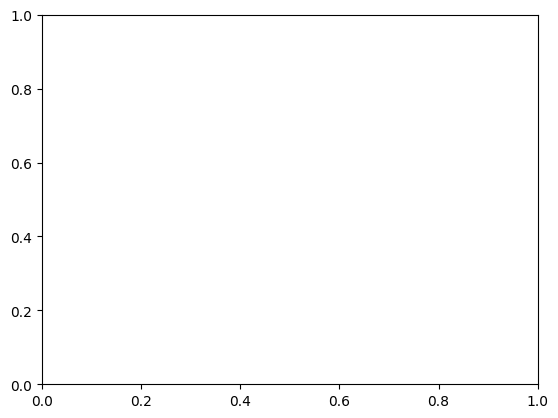

In [ ]:
def improved_plot_structure(Nodes, C_filtered, member_forces_filtered):
    # Initialize the plot with matplotlib.
    fig, ax = plt.subplots()

    # Plot only the members that carry significant forces after optimization.
    for i, connection in enumerate(C_filtered):
        idx = np.where(connection != 0)[0]  # Indices of nodes for this member.
        if abs(member_forces_filtered[i]) > 0:  # Check if member force is significant (non-zero).
            color = 'r' if member_forces_filtered[i] > 0 else 'b'  # Tensile in red, compressive in blue.
            ax.plot(Nodes[idx, 0], Nodes[idx, 1], c=color, lw=2)

    # Add a scatter plot for the nodes with a larger size and green color.
    ax.scatter(Nodes[:,0], Nodes[:,1], s=50, color='green', zorder=5)

    # Set labels and title for the plot for better readability.
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Structure with Optimized Member Forces')
    ax.grid(True)  # Add a grid to the plot for reference.

    # Define custom legend entries for the plot.
    red_patch = plt.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Nodes')
    red_line = plt.Line2D([], [], color='red', lw=2, label='Tensile Members')
    blue_line = plt.Line2D([], [], color='blue', lw=2, label='Compressive Members')

    # Create and add the legend to the plot with the custom entries.
    ax.legend(handles=[red_patch, red_line, blue_line])

    plt.show()  # Display the plot.

# Call the function with the nodes, connectivity matrix, and optimized member forces.
improved_plot_structure(Nodes_2D, C_filtered, member_forces_filtered)

# Print the status of the solver after solving the optimization problem.
print("Solver status:", prob.status)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming L is the length of the beam and P is the load applied at the end of the cantilever beam
# These values should be defined earlier in your script where you are setting up the problem
# L = 4  # Length of the beam in meters
# P = -1  # Load applied at the end of the beam in newtons (should be the actual load from F_ext)

def plot_bending_moment_diagram(L, P, num_points=100):
    # x is a linear space from the start to the end of the beam
    x = np.linspace(0, L, num_points)
    # The bending moment at any point is the load P times the distance from that point to the end of the beam
    M = P * (L - x)  # Calculate the bending moment at each point along the beam

    # Create the plot
    fig, ax = plt.subplots()
    ax.plot(x, M, label='Bending Moment', color='blue')  # Plot the bending moment along the beam
    ax.fill_between(x, M, alpha=0.2, color='blue')  # Fill under the curve for better visualization
    ax.set_xlabel('Length along the beam (m)')  # Set the label for the x-axis
    ax.set_ylabel('Bending Moment (Nm)')  # Set the label for the y-axis
    ax.set_title('Bending Moment Diagram for Cantilever Beam')  # Set the title of the plot
    ax.grid(True)  # Enable the grid for easier reading of values
    ax.legend()  # Add a legend to the plot
    plt.show()  # Display the plot

# Replace P_placeholder with the actual load value extracted from F_ext
# For example, if F_ext is a list or array, you might have something like:
# P_actual = F_ext[iLoadNode, 1]  # Assuming F_ext[iLoadNode, 1] is the load at the load node
# Then you would call the function as follows:
# plot_bending_moment_diagram(L, P_actual)


In [ ]:
# Function to plot the shear force diagram for a cantilever beam with an end load P
def plot_shear_force_diagram(L, P, num_points=100):
    x = np.linspace(0, L, num_points)
    V = np.full(num_points, P)  # Shear force is constant and equal to P along the beam

    fig, ax = plt.subplots()
    ax.plot(x, V, label='Shear Force')
    ax.set_xlabel('Length along the beam (m)')
    ax.set_ylabel('Shear Force (N)')
    ax.set_title('Shear Force Diagram for Cantilever Beam')
    ax.grid(True)
    ax.legend()
    plt.show()

# Call the function to plot the shear force diagram
plot_shear_force_diagram(L, P_placeholder)


NameError: name 'P_placeholder' is not defined

The bending moment and shear force diagrams appear to be correct for a cantilever beam, and we were able to find an optimal solution.

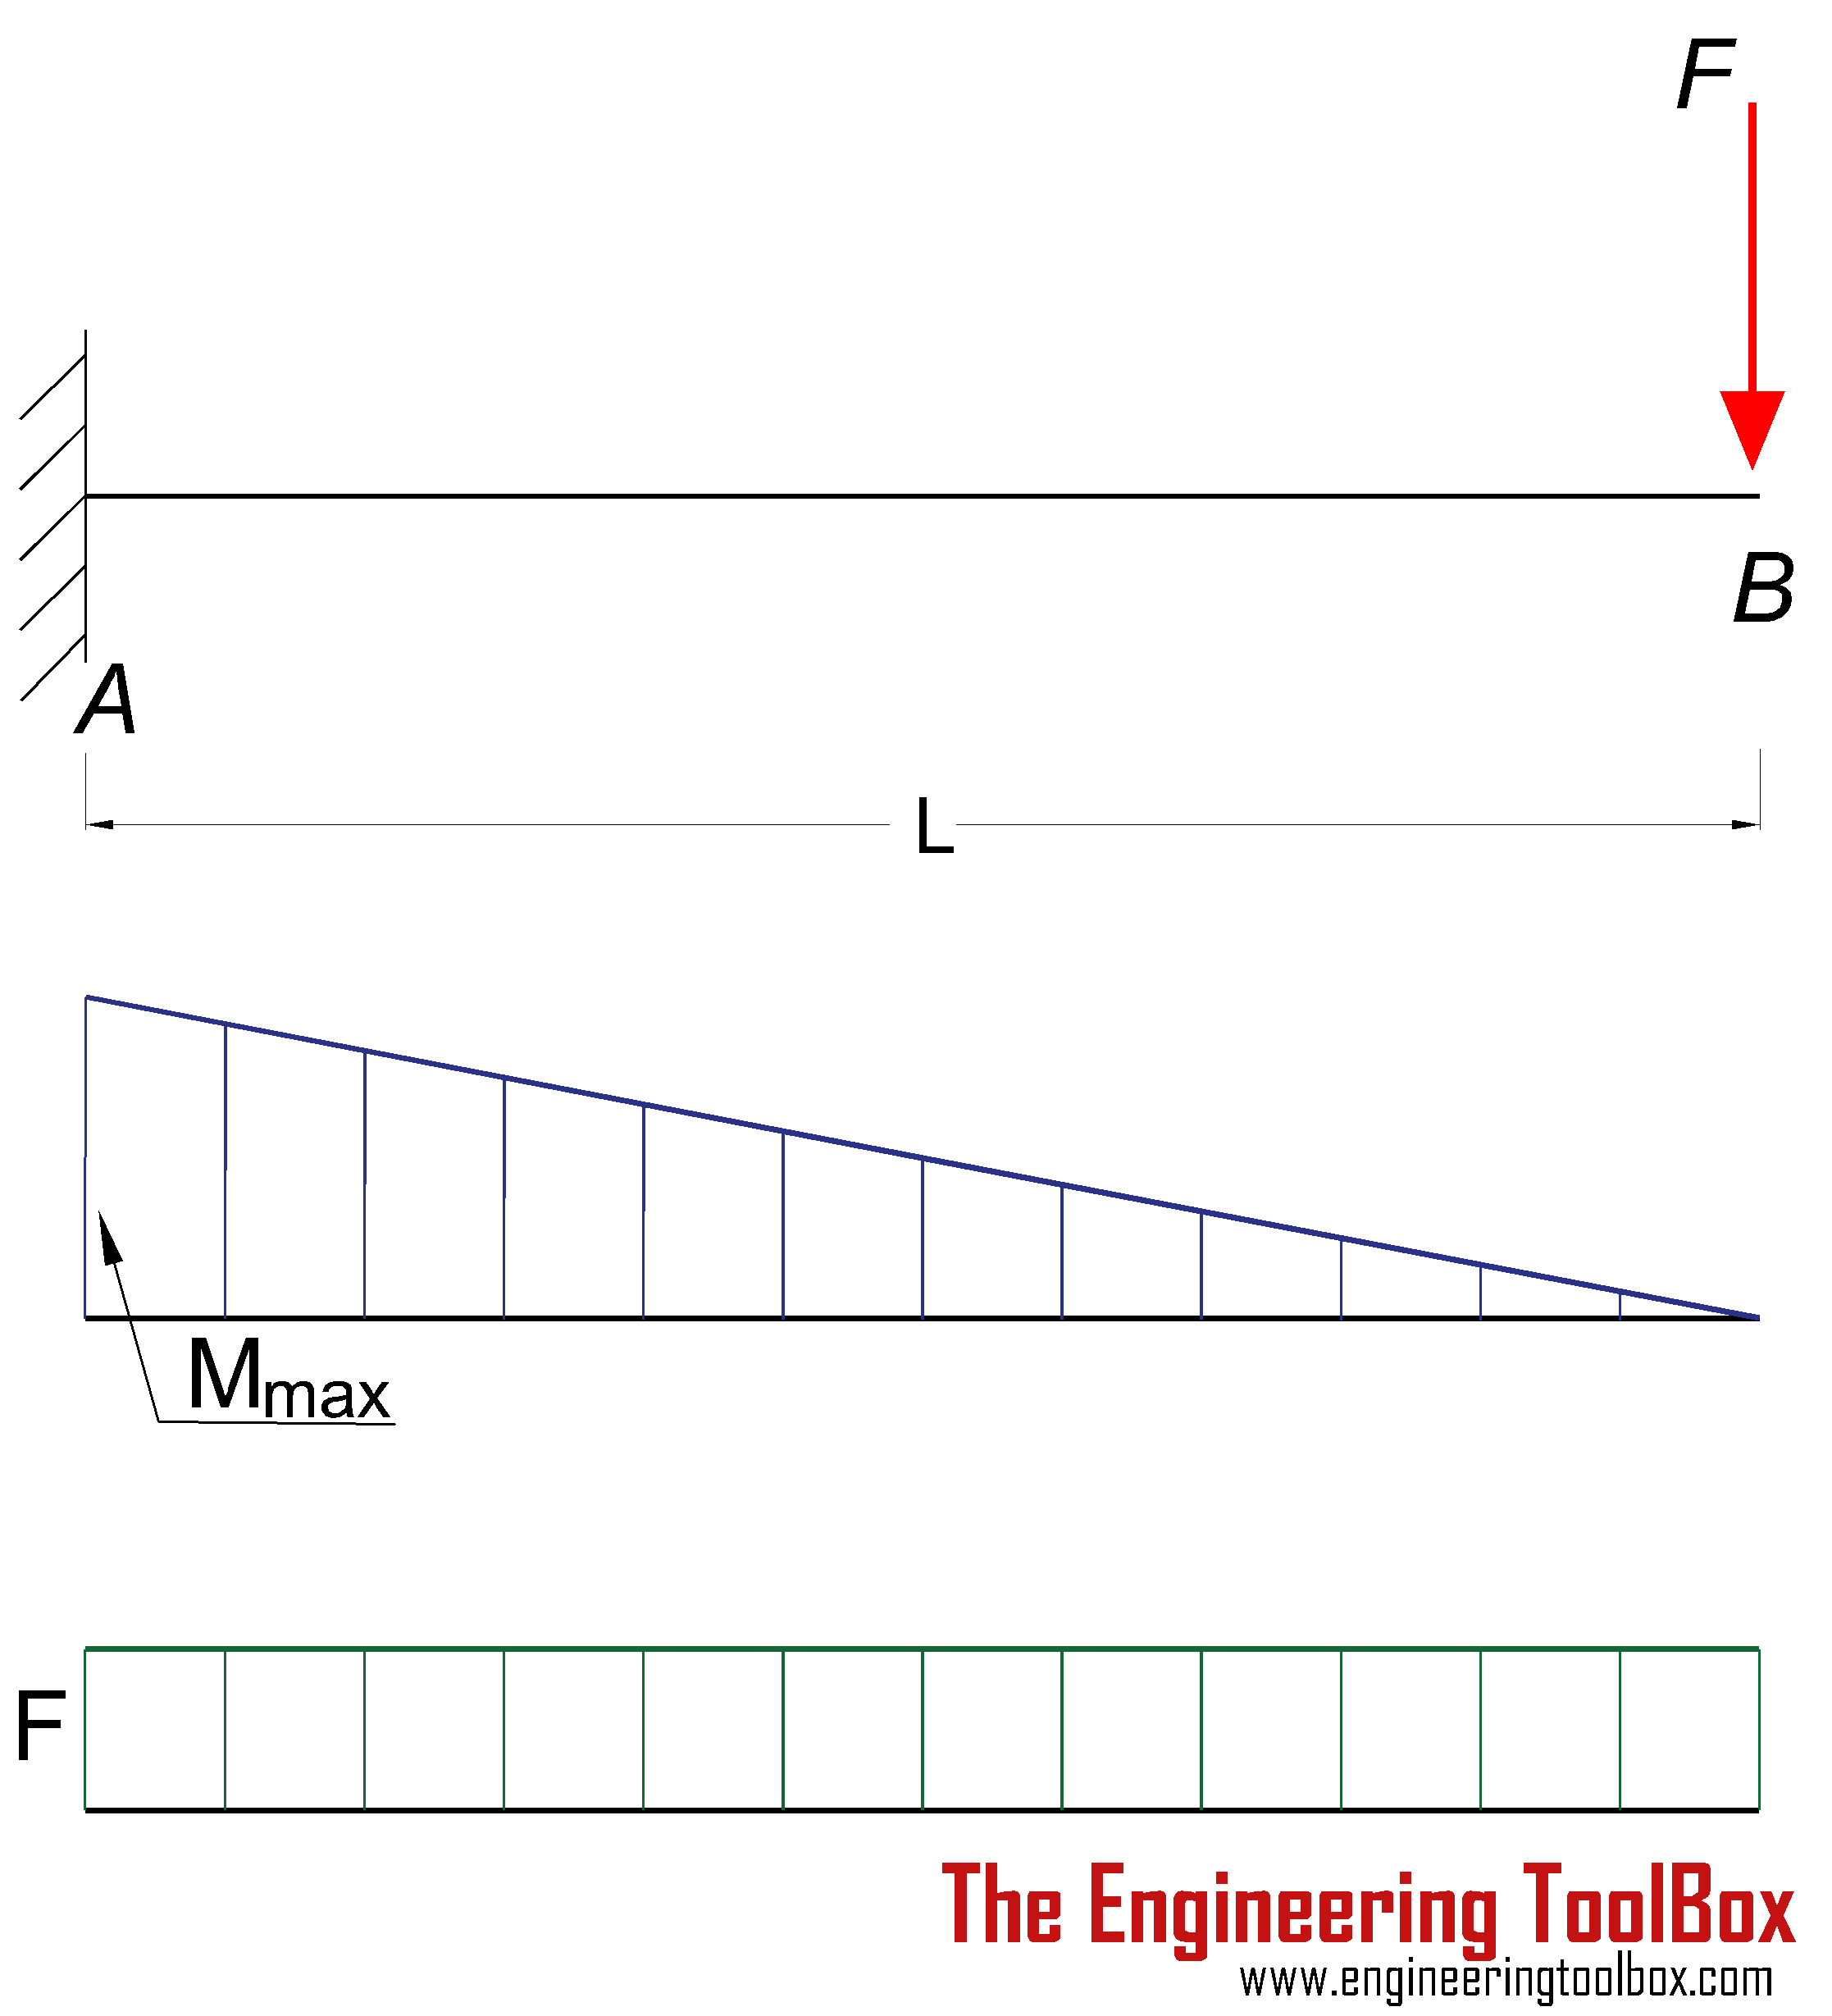

In [ ]:
import numpy as np
import cvxpy as cp

# Constants and Parameters
# Assuming material properties and structure dimensions are given
E = 2.1e11  # Young's modulus in Pa
rho = 7850  # Density in kg/m^3
yield_stress = 350e6  # Yield stress in Pa
length = 2.0  # Length of the cantilever in meters
force = -10000  # Load in N (negative for downward force)
num_elements = 10  # Number of elements in the discretized structure

# Discretization
element_length = length / num_elements
nodes = np.linspace(0, length, num_elements + 1)

# Optimization Variables
cross_section_areas = cp.Variable(num_elements, nonneg=True)
force_densities = cp.Variable(num_elements)

# Objective: Minimize total mass
volume = cp.sum(cross_section_areas * element_length)
mass = volume * rho
objective = cp.Minimize(mass)

# Constraints
equilibrium_constraints = []
for i in range(1, num_elements):
    equilibrium_constraints.append(
        cp.sum(force_densities[:i]) - cp.sum(force_densities[i:]) == 0
    )

# Stress constraints (assuming uniform stress distribution)
stress_constraints = [
    force_densities[i] * E * element_length / cross_section_areas[i] <= yield_stress
    for i in range(num_elements)
]

# Buckling constraints (for compressive forces)
buckling_constraints = [
    force_densities[i] * E * element_length**2 / (cross_section_areas[i] * np.pi**2) <= yield_stress
    for i in range(num_elements) if force_densities[i] < 0
]

# Load application (last node)
load_constraint = [cp.sum(force_densities) == force]

# Problem Definition and Solution
problem = cp.Problem(objective, equilibrium_constraints + stress_constraints + buckling_constraints + load_constraint)
problem.solve()

# Results
print("Optimal Cross-Section Areas (m^2):", cross_section_areas.value)
print("Total Mass (kg):", mass.value)


NotImplementedError: Strict inequalities are not allowed.